# Build a Wavenet

## Preparation

### Prepare the datasets

In [2]:
# Import the libraries
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline
import random

# seed for reproductibility
torch.manual_seed(42)

# load the dataset
with open(file="datasets/names.txt", mode="r") as namestxt:
    words = namestxt.read().splitlines() 
    
# build a dictionary for the characters
chars = ["."] + sorted(list(set("".join(words))))
stoi = {s:i for i, s in enumerate(chars)}
itos = {i:s for s, i in stoi.items()}
vocab_size = len(itos)

# shuffle the words
random.seed(42)
random.shuffle(words)

# build the dataset
block_size = 3 # lengths of sequence of token 
def build_dataset(words, train=0.8, dev=0.1, test=0.1): # helper function to create datasets
	if train + test + dev != 1:
		return ValueError
	
	X, Y = [], []
	for word in words:
		context = [0]*block_size
		for char in word + ".":
			ix = stoi[char]
			X.append(context)
			Y.append(ix)
			context = context[1:]+[ix]
	X = torch.tensor(X)
	Y = torch.tensor(Y)

	n1 = int(train*(len(words)))
	n2 = int((train + dev)*(len(words)))

	Xtr, Ytr = X[:n1], Y[:n1]
	Xdev, Ydev = X[n1:n2], Y[n1:n2]
	Xtest, Ytest = X[n2:], Y[n2:]

	return Xtr, Ytr, Xdev, Ydev, Xtest, Ytest

Xtr, Ytr, Xdev, Ydev, Xtest, Ytest = build_dataset(words=words)

### Visualize the datasets

In [3]:
for x, y in zip(Xtr[:7], Ytr[:7]):
	print("".join(itos[ix.item()] for ix in x), "--->", itos[y.item()])

... ---> y
..y ---> u
.yu ---> h
yuh ---> e
uhe ---> n
hen ---> g
eng ---> .


### Create some Layers Modules

In [4]:
class Linear: # linear layer

	def __init__(self, fan_in, fan_out, bias = True):
		self.weight = torch.randn((fan_in, fan_out))/(fan_in**0.5)
		self.bias = torch.zeros(fan_out) if bias else None
	
	def __call__(self, x):
		self.out = x @ self.weight
		if self.bias is not None:
			self.out += self.bias
		return self.out

	def parameters(self):
		return [self.weight] + ([] if self.bias == None else [self.bias])
	
class Batchnorm1d:

	def __init__(self, dim, eps=1e-5, momentum=0.1):
		self.eps = eps
		self.momentum = momentum
		self.training = True
		# parameters trained with backprop
		self.gamma = torch.ones(dim)
		self.beta = torch.zeros(dim)
		# buffer, trained with running mean and var
		self.running_mean = torch.zeros(dim)
		self.running_var = torch.ones(dim)

	def __call__(self, x):
		# calculate batch mean and var during training, running mean and var for inference
		if self.training:
			xmean = x.mean(0, keepdim = True)
			xvar = x.var(0, keepdim = True)
		# for inference
		else:
			xmean = self.running_mean
			xvar = self.running_var
		xhat = (x-xmean)/torch.sqrt(xvar + self.eps)
		self.out = self.gamma * xhat + self.beta
		# if training, update the running mean and variance
		if self.training:
			with torch.no_grad():
				self.running_mean = self.running_mean * (1-self.momentum) + xmean * self.momentum
				self.running_var = self.running_var * (1-self.momentum) + xvar * self.momentum
		
		return self.out

	def parameters(self):
		return [self.gamma,self.beta]

class Tanh:
	def __call__(self, x):
		self.out = torch.tanh(x)
		return self.out
	def parameters(self):
		return []

## Neural network

### Build the NN

In [5]:
n_emb = 10 # dimension of embedding layer
n_hidden = 200 # dimension of the hidden layer

# layers of the NN
C = torch.randn(vocab_size, n_emb) # word embedding
layers = [
	Linear(fan_in = (n_emb*block_size), fan_out = n_hidden, bias=False),
	Batchnorm1d(dim = n_hidden),
	Tanh(),
	Linear(fan_in= n_hidden, fan_out= vocab_size)
]

# smooth parameter init last Layer (less confident)
with torch.no_grad():
	layers[-1].weight *= 0.1 

# create list of all parameters
parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(f"Number of parameters in the NN = {sum(p.nelement() for p in parameters)}")

# requires grad
for p in parameters:
	p.requires_grad = True

Number of parameters in the NN = 12097


### Training the NN

torch.Size([32, 3]) torch.Size([32])
Loss of step 0 from 1 = 1.758811116218567


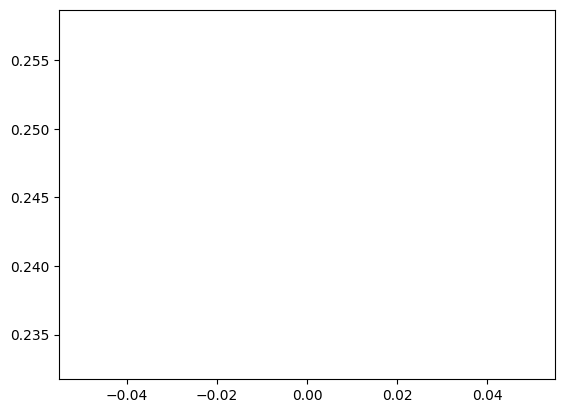

In [37]:
max_steps = 1 # TODO desactivate
# max_steps = 200000 # TODO activate
batch_size = 32
lossi = []
train_size = Xtr.shape[0]

for i in range(max_steps):
	# build minibatch
	ix = torch.randint(low=0,high=train_size,size=(batch_size,))
	Xb, Yb = Xtr[ix], Ytr[ix] 

	# forward pass
	emb = C[Xb] # embedding the individual tokens 
	x = emb.view(batch_size, (block_size*n_emb)) # concatenate the vectors (one row per set of 3 token)
	for layer in layers:
		x = layer(x) # go through the layers of the NN 
	loss = F.cross_entropy(input=x, target=Yb) # loss function
	print(Xb.shape, Yb.shape)
	
	# backward pass
	for p in parameters:
		p.grad = None
	loss.backward()
	
	# update weights (simple Stochastic Gradient Descent)
	for p in parameters:
		lr = 0.1 if i<(max_steps*0.75) else 0.01 #learning rate decay
		p.data -= p.grad * lr
	
	# track stats
	lossi.append(loss.log10().item())
	if i%10000 == 0:
		print(f"Loss of step {i} from {max_steps} = {loss}")
# Plot the result of the training
plt.plot(lossi)

### Evaluate the performance of the NN

In [7]:
# desactivate the training mode for inference
for layer in layers:
    layer.training = False
    
@torch.no_grad()
def split_loss(split):
    x, y = {
        "train": (Xtr, Ytr),
        "val": (Xdev, Ydev),
        "test": (Xtest, Ytest)
	}[split]
    emb = C[x]
    x = emb.view(emb.shape[0], -1)
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, y)
    print(f"{split} loss = {loss}")

split_loss("train")
split_loss("val")

train loss = 1.8166677951812744
val loss = 2.340102195739746


### Sample from the model

In [33]:
# function to sample from the model
def sampleNames(sample_size = 20):
	for _ in range(sample_size):
		context = [0] * block_size
		out = []
		# a while loop for each sample
		while True:
			# forward pass
			emb = torch.Tensor(size=(3,10))
			for i in range(len(context)):
				emb[i] = C[context[i]]
			x = emb.view(emb.shape[0]*emb.shape[1])
			for layer in layers:
				x = layer(x)
			probs = F.softmax(input=x, dim = 1) # probability distribution for each token
			ix = torch.multinomial(input=probs, num_samples=1, replacement=False).item()
			context = [ix] + context[1:]
			out.append(ix)
			if ix == 0:
				break
		print("".join(itos[i] for i in out))
	
sampleNames()

mo.
yntyeaala.
aaja.
fhldl.
bii.
h.
pfhl.
cctll.
n.
jhl.
jvajhlaaa.
ribhs.
aa.
veaaytaaa.
qi.
jakaaval.
o.
ve.
kdcntela.
l.


In [34]:
train_size

25626